In [56]:
import json

import numpy as np
import cv2

from PIL import Image

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from sklearn.model_selection import train_test_split
import copy

In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm

In [5]:
batch_size = 32

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [7]:
!wget http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip

--2023-06-13 19:45:17--  http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip
Resolving domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)... 128.2.220.8
Connecting to domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)|128.2.220.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 589711996 (562M) [application/zip]
Saving to: ‘hand_labels.zip’

hand_labels.zip     100%[===================>] 562.39M  10.9MB/s    in 48s     

2023-06-13 19:46:06 (11.8 MB/s) - ‘hand_labels.zip’ saved [589711996/589711996]



In [8]:
!unzip hand_labels.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: hand_labels/manual_test/ex2_2.flv_000007_l.json  
  inflating: hand_labels/manual_test/Berry_roof_story.flv_000047_r.jpg  
  inflating: hand_labels/manual_test/003757109_01_l.json  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000019_l.jpg  
  inflating: hand_labels/manual_test/075338811_01_r.jpg  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000069_l.json  
  inflating: hand_labels/manual_test/092033356_04_l.jpg  
  inflating: hand_labels/manual_test/070301896_02_r.jpg  
  inflating: hand_labels/manual_test/ex2_2.flv_000080_r.json  
  inflating: hand_labels/manual_test/ex2_2.flv_000002_r.jpg  
  inflating: hand_labels/manual_test/069318700_02_r.json  
  inflating: hand_labels/manual_test/043285111_01_r.jpg  
  inflating: hand_labels/manual_test/098925624_03_r.jpg  
  inflating: hand_labels/manual_test/041354052_01_l.jpg  
  inflating: hand_labels/manual_test/Berry_sermon_stor

# Prepare data

Dataset: [Hand Keypoint Detection in Single Images
using Multiview Bootstrapping](http://domedb.perception.cs.cmu.edu/handdb.html)

In [9]:
files = [os.path.join('hand_labels/manual_train', file) for file in os.listdir('hand_labels/manual_train')]

In [15]:
files[1]

'Alexander_a_visit_to_the_cafe.flv_000074_r.json'

In [17]:
split1 = json.load(open(os.path.join('hand_labels/manual_train', files[1])))

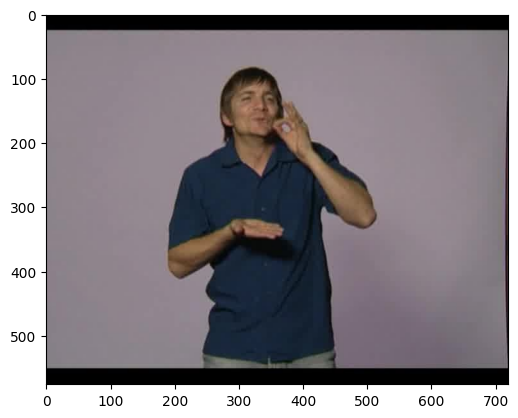

In [25]:
img_path = os.path.join('hand_labels/manual_train', files[1].replace('.json', '.jpg'))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

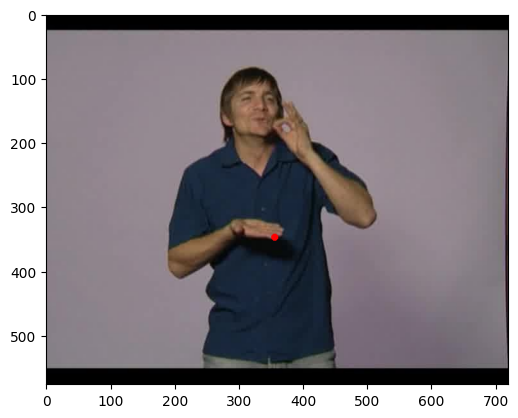

In [31]:
img_new = img.copy()
x_pos, y_pos = int(split1['hand_pts'][8][0]), int(split1['hand_pts'][8][1])
img_new = cv2.circle(img_new, (x_pos, y_pos), 3, (255, 0, 0), 4)

plt.imshow(img_new)

In [22]:
split1['hand_pts']

[[303.7593078613281, 328.51190185546875, 1.0],
 [298.14999389648443, 327.3944702148438, 1.0],
 [295.3453369140625, 331.02618408203125, 1.0],
 [298.43048095703125, 335.21658325195307, 1.0],
 [301.23513793945307, 339.12765502929693, 1.0],
 [318.90447998046875, 340.8038330078125, 1.0],
 [336.01290893554693, 344.43554687499994, 1.0],
 [344.42687988281244, 345.83233642578125, 1.0],
 [356.4869079589842, 347.22915649414057, 1.0],
 [325.91613769531244, 336.3340454101563, 1.0],
 [343.3050231933595, 339.4070129394531, 1.0],
 [357.6087951660156, 342.2006530761719, 1.0],
 [367.70556640624994, 343.5974426269532, 1.0],
 [331.5254516601563, 331.8642578125, 1.0],
 [348.07293701171875, 335.49597167968744, 1.0],
 [359.5720520019531, 336.3340454101563, 1.0],
 [369.10787963867193, 336.05468750000006, 1.0],
 [335.1715087890625, 326.8357543945313, 1.0],
 [348.63388061523443, 329.9087219238281, 1.0],
 [356.20645141601557, 330.46743774414057, 1.0],
 [363.05459594726557, 329.5556640625, 1.0]]

In [10]:
files_paths = []
files = sorted(files)
len_dataset = 350
i = 0
for file_path in files:
    if i >= len_dataset:
        break
    is_jpg = file_path.split('.')[-1] == 'jpg'
    side = file_path.split('.')[-2].split('_')[-1]
    if side == 'r' and is_jpg:
        files_paths.append(file_path)
        i += 1

In [11]:
len(files_paths)

350

In [12]:
train_paths = files_paths[:250]
val_paths = files_paths[250:]

# ANNOTATIONS

In [13]:
def get_annotations(paths):
    annotations = []
    for curr_path in paths:
        json_path = curr_path.replace('.jpg', '.json')
        split = json.load(open(json_path))

        annotations.append(split)
    return annotations

In [14]:
train_meta = get_annotations(train_paths)
val_meta = get_annotations(val_paths)

In [43]:
np.array(train_meta[0]['hand_pts'])[:, :2].ravel()

array([461.87872314, 497.2376709 , 477.00186157, 504.04269409,
       492.125     , 518.01092529, 493.20523071, 535.56066895,
       484.92349243, 545.94732666, 472.32089233, 516.22009277,
       470.52050781, 533.41174316, 473.76119995, 539.50042725,
       475.20147705, 532.33728027, 458.99813843, 509.41506958,
       456.47763062, 534.12805176, 461.87872314, 536.99334717,
       461.87872314, 526.96490479, 445.67538452, 510.84771729,
       444.95523071, 533.41174316, 446.39553833, 531.26281738,
       447.47573853, 525.17407227, 436.67352295, 509.41506958,
       435.95336914, 530.54644775, 441.71456909, 534.48620605,
       443.15484619, 527.68121338])

In [67]:
class KeypointsDataset(Dataset):

    def __init__(self, meta, paths):
        self.meta = meta
        self.paths = paths
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.paths[idx]
        image = Image.open(image_name).convert('RGB')
        image = np.asarray(image)

        x_min = int(np.array(self.meta[idx]['hand_pts'])[:, 0].min())
        x_max = int(np.array(self.meta[idx]['hand_pts'])[:, 0].max())
        y_min = int(np.array(self.meta[idx]['hand_pts'])[:, 1].min())
        y_max = int(np.array(self.meta[idx]['hand_pts'])[:, 1].max())
        image = image[y_min:y_max,x_min:x_max]

        image = self.preprocessing(image=image)['image']

        keypoints = np.array(self.meta[idx]['hand_pts'])
        keypoints[:, 0] -= x_min
        keypoints[:, 0] /= (x_max - x_min)
        keypoints[:, 1] -= y_min
        keypoints[:, 1] /= (y_max - y_min)

        keypoints = keypoints[:, :2].ravel()
        # for i in range(0, len(self.meta[idx]['keypoints']), 3):
        #     keypoints.append((self.meta[idx]['keypoints'][i] - x_min) / (x_max - x_min))
        #     keypoints.append((self.meta[idx]['keypoints'][i+1] - y_min) / (y_max - y_min))
        #     keypoints.append(float(self.meta[idx]['keypoints'][i+2] > 0))

        return image, torch.Tensor(keypoints)

In [68]:
train_dataset = KeypointsDataset(meta=train_meta, paths=train_paths)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

val_dataset = KeypointsDataset(meta=val_meta, paths=val_paths)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

183
86


151
77


90
22


246


46


142


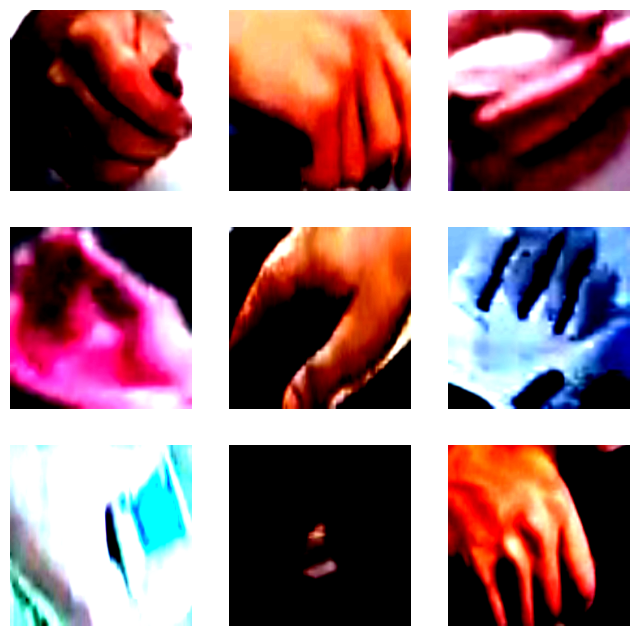

In [31]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    print(sample_idx)
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Metrics

In [69]:
def get_metric(y_true, y_pred):
    # Евклидово расстояние

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    return distances.mean()

# Create model

In [70]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(62720, 42),
    nn.Sigmoid()
)
model.to(device);

# Train

In [71]:
EPOCHS = 100
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr)

criterion = nn.MSELoss()

In [72]:
best_metric = 1000
best_model = copy.deepcopy(model)
for epoch in range(EPOCHS):

    model.train()

    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()

        batch = batch.to(device)
        targets = targets.to(device)

        predictions = model(batch)

        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        predictions = predictions.cpu().detach().numpy().reshape(-1, 2)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 2)
        train_targets.extend(targets)

    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train metric:', get_metric(train_targets[:, :2], train_predictions[:, :2]))

    model.eval()

    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):

        with torch.no_grad():

            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)

            predictions = predictions.cpu().numpy().reshape(-1, 2)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 2)
            val_targets.extend(targets)

    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    val_metric = get_metric(val_targets[:, :2], val_predictions[:, :2])
    print('Val metric:', val_metric)
    if val_metric < best_metric:
        best_model = copy.deepcopy(model)
        best_metric = val_metric

Epoch: 0:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0805965427841459
Train metric: 0.36331826


Epoch: 0:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.3335092


Epoch: 1:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.02952433191239834
Train metric: 0.20888913


Epoch: 1:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.33094633


Epoch: 2:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.013569510408810206
Train metric: 0.13998643


Epoch: 2:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.31436688


Epoch: 3:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0069223663636616296
Train metric: 0.10187174


Epoch: 3:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.3023928


Epoch: 4:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.004871316320661988
Train metric: 0.08592455


Epoch: 4:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.298742


Epoch: 5:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.003232658341793077
Train metric: 0.07023003


Epoch: 5:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29506913


Epoch: 6:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0026828376576304436
Train metric: 0.06381144


Epoch: 6:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29353592


Epoch: 7:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.002195251723086195
Train metric: 0.057684205


Epoch: 7:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29237


Epoch: 8:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0019495766277291945
Train metric: 0.05422775


Epoch: 8:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2925236


Epoch: 9:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001810110207380993
Train metric: 0.052001175


Epoch: 9:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29310325


Epoch: 10:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001971173915080726
Train metric: 0.05458931


Epoch: 10:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29158065


Epoch: 11:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.00179258847076978
Train metric: 0.05189646


Epoch: 11:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29324207


Epoch: 12:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0017820887234328048
Train metric: 0.051407576


Epoch: 12:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29299426


Epoch: 13:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0019228077560131038
Train metric: 0.05307745


Epoch: 13:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29415855


Epoch: 14:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0017608168667980603
Train metric: 0.050467655


Epoch: 14:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29234532


Epoch: 15:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001798976811447314
Train metric: 0.05114337


Epoch: 15:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29154867


Epoch: 16:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0017611084040254354
Train metric: 0.050678253


Epoch: 16:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29373178


Epoch: 17:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001546421104909054
Train metric: 0.047934778


Epoch: 17:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2922135


Epoch: 18:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0016677537434069173
Train metric: 0.0487499


Epoch: 18:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29445347


Epoch: 19:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0016746530974549906
Train metric: 0.049572933


Epoch: 19:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2922879


Epoch: 20:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0016111966521878327
Train metric: 0.04888601


Epoch: 20:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29349485


Epoch: 21:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001627007349660354
Train metric: 0.048564702


Epoch: 21:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29456457


Epoch: 22:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001585374353453517
Train metric: 0.04781747


Epoch: 22:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29286614


Epoch: 23:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0014537197670766286
Train metric: 0.046119697


Epoch: 23:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29395124


Epoch: 24:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001403938463356878
Train metric: 0.045102637


Epoch: 24:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29380152


Epoch: 25:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0014407438824751548
Train metric: 0.045666054


Epoch: 25:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29158044


Epoch: 26:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0015449562010222248
Train metric: 0.04679556


Epoch: 26:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2926445


Epoch: 27:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001417420372100813
Train metric: 0.044944953


Epoch: 27:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29192266


Epoch: 28:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0015570334923852766
Train metric: 0.046892736


Epoch: 28:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2927436


Epoch: 29:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.00140288527057107
Train metric: 0.044692617


Epoch: 29:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29296196


Epoch: 30:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001384034935784127
Train metric: 0.04468372


Epoch: 30:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2945875


Epoch: 31:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0014816369262656995
Train metric: 0.045799848


Epoch: 31:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29400006


Epoch: 32:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0013705449611214654
Train metric: 0.043958593


Epoch: 32:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29478472


Epoch: 33:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0013942902109452657
Train metric: 0.044571254


Epoch: 33:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29410702


Epoch: 34:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.00139036204200238
Train metric: 0.044500493


Epoch: 34:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29334977


Epoch: 35:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0013522019144147635
Train metric: 0.044494778


Epoch: 35:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2930282


Epoch: 36:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0013969975490389125
Train metric: 0.04431354


Epoch: 36:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29444593


Epoch: 37:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0014268730467717563
Train metric: 0.045035776


Epoch: 37:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29344523


Epoch: 38:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0013810685985455556
Train metric: 0.04399874


Epoch: 38:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2941392


Epoch: 39:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012488025074292506
Train metric: 0.042480983


Epoch: 39:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29320928


Epoch: 40:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012360957501057004
Train metric: 0.041661274


Epoch: 40:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2936828


Epoch: 41:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012141872347066446
Train metric: 0.04153392


Epoch: 41:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2923597


Epoch: 42:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012176444454650795
Train metric: 0.041557807


Epoch: 42:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2933081


Epoch: 43:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001353182696870395
Train metric: 0.04381228


Epoch: 43:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29385614


Epoch: 44:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012922285656843866
Train metric: 0.042717766


Epoch: 44:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2927586


Epoch: 45:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0011926252295130066
Train metric: 0.04142462


Epoch: 45:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29392463


Epoch: 46:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012417350746025996
Train metric: 0.042388223


Epoch: 46:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2923156


Epoch: 47:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012140025916908468
Train metric: 0.04148257


Epoch: 47:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2925834


Epoch: 48:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012416077328712813
Train metric: 0.04216907


Epoch: 48:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29136345


Epoch: 49:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0013174823585099407
Train metric: 0.043675132


Epoch: 49:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29334983


Epoch: 50:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0012565054764438952
Train metric: 0.041908972


Epoch: 50:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2924686


Epoch: 51:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0011550146570828343
Train metric: 0.04027406


Epoch: 51:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29387456


Epoch: 52:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001163077906572393
Train metric: 0.04066669


Epoch: 52:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2930676


Epoch: 53:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0010798776555540307
Train metric: 0.039485034


Epoch: 53:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2941171


Epoch: 54:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0011175943156039076
Train metric: 0.040205717


Epoch: 54:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29399973


Epoch: 55:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0010440762853249907
Train metric: 0.038645368


Epoch: 55:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29258305


Epoch: 56:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.001032787125690707
Train metric: 0.038798988


Epoch: 56:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2931458


Epoch: 57:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0011409602427322949
Train metric: 0.04033848


Epoch: 57:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2937353


Epoch: 58:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0010491893460441912
Train metric: 0.039350677


Epoch: 58:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29354823


Epoch: 59:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.00112837617884257
Train metric: 0.03980427


Epoch: 59:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.2932512


Epoch: 60:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0010554269039338188
Train metric: 0.038814608


Epoch: 60:   0%|          | 0/4 [00:00<?, ?it/s]

Val metric: 0.29447877


Epoch: 61:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [73]:
print('Лучшая метрика', best_metric)

Лучшая метрика 0.29136345


In [74]:
torch.save(best_model, 'mobilenetv2_050_0291.pt')

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
!cp mobilenetv2_050_0291.pt "/content/drive/MyDrive/Colab Notebooks/ИТМО/Computer Vision/Pose Estimation/models/"

# Inference

In [91]:
model_path = "/content/drive/MyDrive/Colab Notebooks/ИТМО/Computer Vision/Pose Estimation/models/mobilenetv2_050_0291.pt"
best_model_mobilenet = torch.load(model_path, map_location=device)

In [98]:
val_id = 4
image_path = val_paths[val_id]
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

x_min = int(np.array(val_meta[val_id]['hand_pts'])[:, 0].min())
x_max = int(np.array(val_meta[val_id]['hand_pts'])[:, 0].max())
y_min = int(np.array(val_meta[val_id]['hand_pts'])[:, 1].min())
y_max = int(np.array(val_meta[val_id]['hand_pts'])[:, 1].max())
image = image[y_min:y_max,x_min:x_max]

pred = best_model_mobilenet(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

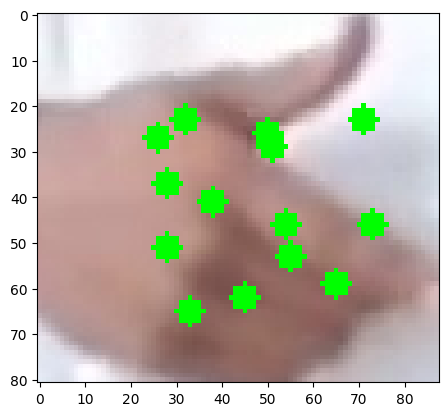

In [99]:
for i in range(0, len(pred), 3):
    # if pred[i+2] > 0.75:
    x = int(pred[i] * (x_max-x_min))
    y = int(pred[i+1] * (y_max-y_min))
    cv2.circle(image, (x, y), 0, (0, 255, 0), 5)
plt.imshow(image)